In [1]:
import numpy as np
import geopandas as gp
import pandas as pd
from rasterio.plot import show
import rasterio as rio
import rasterio.features
import rasterio.warp
import earthpy.spatial as es
import tarfile
import os
from shapely.geometry import Polygon
from matplotlib import pyplot
import matplotlib.pyplot as plt
import json
import pickle
import pyproj;                                 #pyproj.set_datapath("C:/Users/User/Anaconda3/envs/geo/Lib/site-packages/pyproj")
import landsatxplore.api
from landsatxplore.earthexplorer import EarthExplorer                                  # https://pypi.org/project/landsatxplore/
from collections.abc import Iterable
import time
import math
from ipypb import track
import seaborn as sn
import urllib
import sys

os.chdir(r"C:\Users\User\Documents\Work\SDGs and AI\6.3.2")

### Read in list of sites for download

In [2]:
sites = pd.read_pickle("sites.p")

In [3]:
### Creat list of scenes to download

dll = sites[(sites['l8_scene_id'].notna())|(sites['l7_scene_id'].notna())].drop(['lat','lon'],axis=1)

dll['downloaded'] = False

---


## Using ESPA API

<br>

### Create list of scenes for download

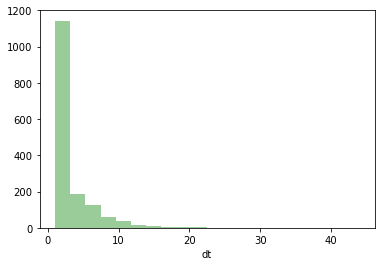

In [4]:
sites_anal = sites[(sites['l7_scene_id'].notna())|(sites['l8_scene_id'].notna())].reset_index()
temp = sites_anal.groupby('sid').count()
sn.distplot(temp.dt,kde=False,bins=20,color='g')

In [5]:
temp[temp.dt>9].head()

,dt,wb_cat,determinand_id,value,lon,lat,geometry,checked,l7_scene_n1d10c,l8_scene_n1d10c,l7_scene_id,l7_scene_dt,l8_scene_id,l8_scene_dt,l7_scene_n4d20c,l8_scene_n4d20c
sid,,,,,,,,,,,,,,,,
EL000200030020H500,13,13,13,13,13,13,13,13,13,13,11,11,9,9,9,9
EL000400030058H500,10,10,10,10,10,10,10,10,10,10,5,5,8,8,7,7
EL000400030074N500,10,10,10,10,10,10,10,10,10,10,4,4,9,9,7,7
EL000400030090N500,10,10,10,10,10,10,10,10,10,10,6,6,7,7,7,7
EL000500030040H500,10,10,10,10,10,10,10,10,10,10,5,5,6,6,8,8


In [6]:
sites_anal = sites_anal.set_index(['sid','dt'])

ziplist = zip(sites_anal.index.get_level_values(0),sites_anal.index.get_level_values(1),
              sites_anal.l7_scene_id,sites_anal.l8_scene_id)

for sid,dt,l7_scene_id,l8_scene_id in track(ziplist,len(sites)):
    
    date = dt.strftime("%Y-%m-%d")
    
    if (isinstance(l7_scene_id,str)==True):
        sc_meta7 = pickle.load(open('./Landsat/Scenes/scene_'+str(l7_scene_id)+".p","rb"))
        
        sites_anal.loc[(sid,date),'l7_display_id'] = sc_meta7[0]['displayId']
        sites_anal.loc[(sid,date),'l7_acquisition_dt'] = sc_meta7[0]['acquisitionDate']
        
        del(sc_meta7)

    elif (isinstance(l8_scene_id,str)==True):
        sc_meta8 = pickle.load(open('./Landsat/Scenes/scene_'+str(l8_scene_id)+".p","rb"))
        
        sites_anal.loc[(sid,date),'l8_display_id'] = sc_meta8[0]['displayId']
        sites_anal.loc[(sid,date),'l8_acquisition_dt'] = sc_meta8[0]['acquisitionDate']
        
        del(sc_meta8)

 [██████████████##############################################] 5234/21196 [00:25<00:00, 0.00s/it]

### Create scene list for example site

In [7]:
dll = list(sites_anal.loc['EL000200030020H500',:].l8_display_id.unique())
dll2 = list(sites_anal.loc['EL000200030020H500',:].l7_display_id.unique())

In [8]:
[dll.append(i) for i in dll2 ]

dll = [x for x in dll if str(x) != 'nan']

### Setup API call

In [9]:
import requests
import json
import getpass

username = 'clement.attwood.18@ucl.ac.uk'
password = 'm9.iETxKMtZ6B,q'

host = 'https://espa.cr.usgs.gov/api/v1/'

## espa_api: A Function
First and foremost, define a simple function for interacting with the API. 

The key things to watch for:

* Always scrub for a `"messages"` field returned in the response, it is only informational about a request
  * **Errors** (`"errors"`): Brief exlaination about why a request failed
  * **Warnings** (`"warnings"`): Cautions about a successful response
* Always make sure the requested HTTP `status_code` returned is valid 
  * **GET**: `200 OK`: The requested resource was successfully fetched (result can still be empty)
  * **POST**: `201 Created`: The requested resource was created
  * **PUT**: `202 Accepted`: The requested resource was updated

In [10]:
def espa_api(endpoint, verb='get', body=None, uauth=None):
    """ Suggested simple way to interact with the ESPA JSON REST API """
    auth_tup = uauth if uauth else (username, password)
    response = getattr(requests, verb)(host + endpoint, auth=auth_tup, json=body)
    print('{} {}'.format(response.status_code, response.reason))
    data = response.json()
    if isinstance(data, dict):
        messages = data.pop("messages", None)  
        if messages:
            print(json.dumps(messages, indent=4))
    try:
        response.raise_for_status()
    except Exception as e:
        print(e)
        return None
    else:
        return data

In [11]:
### Check user status

print('GET /api/v1/user')
resp = espa_api('user')
print(json.dumps(resp))

GET /api/v1/user
200 OK
{"email": "clement.attwood.18@ucl.ac.uk", "first_name": "Clement", "last_name": "Attwood", "roles": ["active"], "username": "clement.attwood.18@ucl.ac.uk"}


### Check product availability for scene

In [14]:
for scene in dll:
    avail_list = {'inputs': [scene,
                             'bad_scene_id'  # <-- Note: Unrecognized ID
                            ]
                 }
    resp = espa_api('available-products', body=avail_list)
    
    ### print list of available products for each scene
    products = []
    
    if 'etm7_collection' in resp.keys():  
        products += resp['etm7_collection']['products']    

    else:
        products += resp['olitirs8_collection']['products']


    sr = sum(['sr' in i for i in products])>0
    f'Surface reflectance available for scene: {sr}'

    print(products)

200 OK
['source_metadata', 'l1', 'toa', 'bt', 'sr', 'sr_ndvi', 'sr_evi', 'sr_savi', 'sr_msavi', 'sr_ndmi', 'sr_nbr', 'sr_nbr2', 'stats', 'pixel_qa']
200 OK
['source_metadata', 'l1', 'toa', 'bt', 'sr', 'sr_ndvi', 'sr_evi', 'sr_savi', 'sr_msavi', 'sr_ndmi', 'sr_nbr', 'sr_nbr2', 'stats', 'pixel_qa']
200 OK
['source_metadata', 'l1', 'toa', 'bt', 'sr', 'sr_ndvi', 'sr_evi', 'sr_savi', 'sr_msavi', 'sr_ndmi', 'sr_nbr', 'sr_nbr2', 'stats', 'pixel_qa']
200 OK
['source_metadata', 'l1', 'toa', 'bt', 'sr', 'sr_ndvi', 'sr_evi', 'sr_savi', 'sr_msavi', 'sr_ndmi', 'sr_nbr', 'sr_nbr2', 'stats', 'pixel_qa']
200 OK
['source_metadata', 'l1', 'toa', 'bt', 'sr', 'sr_ndvi', 'sr_evi', 'sr_savi', 'sr_msavi', 'sr_ndmi', 'sr_nbr', 'sr_nbr2', 'stats', 'pixel_qa']
200 OK
['source_metadata', 'l1', 'toa', 'bt', 'sr', 'sr_ndvi', 'sr_evi', 'sr_savi', 'sr_msavi', 'sr_ndmi', 'sr_nbr', 'sr_nbr2', 'stats', 'pixel_qa']
200 OK
['source_metadata', 'l1', 'toa', 'bt', 'sr', 'sr_ndvi', 'sr_evi', 'sr_savi', 'sr_msavi', 'sr_ndmi',

### Return list of availble projections

In [15]:
resp = espa_api('projections', body=avail_list)
resp

200 OK


{'aea': {'type': 'object',
  'title': 'Albers Equal Area',
  'pixel_units': ['meters', 'dd'],
  'display_rank': 0,
  'properties': {'standard_parallel_1': {'type': 'number',
    'title': '1st Standard Parallel',
    'display_rank': 2,
    'required': True,
    'minimum': -90,
    'maximum': 90},
   'standard_parallel_2': {'type': 'number',
    'title': '2nd Standard Parallel',
    'display_rank': 3,
    'required': True,
    'minimum': -90,
    'maximum': 90},
   'central_meridian': {'type': 'number',
    'title': 'Central Meridian',
    'display_rank': 1,
    'required': True,
    'minimum': -180,
    'maximum': 180},
   'latitude_of_origin': {'type': 'number',
    'title': 'Latitude of Origin',
    'display_rank': 0,
    'required': True,
    'minimum': -90,
    'maximum': 90},
   'false_easting': {'type': 'number',
    'title': 'False Easting (meters)',
    'display_rank': 4,
    'required': True},
   'false_northing': {'type': 'number',
    'title': 'False Northing (meters)',
    '

### Create an order

In [26]:
# Differing products across the sensors
l_prods = ['sr']

# # Standard Albers CONUS
projection = 'lonlat'

# {'standard_parallel_1': 29.5,
#                       'standard_parallel_2': 45.5,
#                       'central_meridian': -96.0,
#                       'latitude_of_origin': 23.0,
#                       'false_easting': 0,
#                       'false_northing': 0,
#                       'datum': 'nad83'}

# Let available-products place the acquisitions under their respective sensors
ls = dll

order = espa_api('available-products', body=dict(inputs=ls))

### print inputs
if 'etm7_collection' in order.keys():  
    print(json.dumps(order['etm7_collection']['inputs'],indent=2))   

if 'olitirs8_collection' in order.keys():
    print(json.dumps(order['olitirs8_collection']['inputs'],indent=2))

200 OK
[
  "LE07_L1TP_183034_20130609_20161124_01_T1",
  "LE07_L1TP_184033_20130819_20161122_01_T1",
  "LE07_L1TP_183034_20130929_20161120_01_T1",
  "LE07_L1TP_183034_20140511_20161115_01_T1",
  "LE07_L1TP_184034_20140619_20161113_01_T1",
  "LE07_L1TP_183034_20140714_20161112_01_T1",
  "LE07_L1TP_184034_20140822_20161113_01_T1",
  "LE07_L1TP_183034_20140831_20161112_01_T1",
  "LE07_L1TP_184033_20150724_20161023_01_T1",
  "LE07_L1TP_183034_20150818_20161021_01_T1",
  "LE07_L1TP_183034_20150919_20161019_01_T1"
]
[
  "LC08_L1TP_184033_20130726_20180527_01_T1",
  "LC08_L1TP_184033_20150614_20170408_01_T1"
]


In [27]:
# Replace the available products that was returned with what we want
for sensor in order.keys():
    if isinstance(order[sensor], dict) and order[sensor].get('inputs'):
        if set(ls) & set(order[sensor]['inputs']):
            order[sensor]['products'] = l_prods

# Add in the rest of the order information
#order['projection'] = projection
order['format'] = 'gtiff'
order['resampling_method'] = 'cc'
order['note'] = 'API Demo Jupyter!!'

# Notice how it has changed from the original call available-products
print(json.dumps(order, indent=4))

{
    "olitirs8_collection": {
        "products": [
            "sr"
        ],
        "inputs": [
            "LC08_L1TP_184033_20130726_20180527_01_T1",
            "LC08_L1TP_184033_20150614_20170408_01_T1"
        ]
    },
    "etm7_collection": {
        "products": [
            "sr"
        ],
        "inputs": [
            "LE07_L1TP_183034_20130609_20161124_01_T1",
            "LE07_L1TP_184033_20130819_20161122_01_T1",
            "LE07_L1TP_183034_20130929_20161120_01_T1",
            "LE07_L1TP_183034_20140511_20161115_01_T1",
            "LE07_L1TP_184034_20140619_20161113_01_T1",
            "LE07_L1TP_183034_20140714_20161112_01_T1",
            "LE07_L1TP_184034_20140822_20161113_01_T1",
            "LE07_L1TP_183034_20140831_20161112_01_T1",
            "LE07_L1TP_184033_20150724_20161023_01_T1",
            "LE07_L1TP_183034_20150818_20161021_01_T1",
            "LE07_L1TP_183034_20150919_20161019_01_T1"
        ]
    },
    "format": "gtiff",
    "resampling_metho

### Place the order

In [28]:
resp = espa_api('order', verb='post', body=order)
print(json.dumps(resp, indent=4))

### Write pickle for use later
pickle.dump(resp,open('./Landsat/Downloaded/Orders/'+str(time.time())+'.p','wb'))

201 CREATED
{
    "orderid": "espa-clement.attwood.18@ucl.ac.uk-03022020-080834-340",
    "status": "ordered"
}


### Check order status, retrieve download links and extract to file

#### Simple call

In [31]:
### order status for current order
#orderid = 'espa-clement.attwood.18@ucl.ac.uk-03012020-142322-644'
orderid = resp["orderid"]

### check status once
resp = espa_api('order-status/{}'.format(orderid))
resp['status']

200 OK


'complete'

#### Dowload in for loop

In [ ]:
start_time = time.time()
path = './Landsat/Downloaded/'

## response for latest order
resp = pickle.load(open(path+'Orders/1583158115.1115713.p',"rb"))

while resp['status']=='ordered':

    resp = espa_api('order-status/{}'.format(orderid))

    elapsed_time = round((time.time() - start_time)/60,2)

    print(f'Ordered and checking status...elapsed time {elapsed_time}', end="")

    time.sleep(30)

    if resp['status']=='complete':
        
        break 
        
print('Order complete')

### get order details
dl = espa_api('item-status/{0}'.format(orderid), body={'status': 'complete'})

### create list of links
dllink = []
dllink += [ item.get('product_dload_url') for item in dl[orderid] ]

### Open remote tar and extract scenes from list of download links

for link in track(dllink):

    ## open link and tar
    with urllib.request.urlopen(link) as tardl:
        tar = tarfile.open(fileobj=tardl, mode="r:gz")
    
        ## create list of downloaded files and check contents of tar against it
        dl_files = os.listdir(path)                          # list of files in download directory
        remote_list = [ i.name for i in tar.getmembers() ]   # list of remote files

        ## if not already downloaded then download
        if sum([ i in dl_files for i in remote_list ])<1:
    
            try:
                tar.extractall(path=path)
            except:
                print("File: %r could not be extracted." % tardl)
                tardl_exceptions = []
                tardltardl_exceptions += tardl
    
    tar.close()


200 OK
Ordered and checking status...elapsed time 0.01Order complete
200 OK


 [############################################################] 0/13 [0<0, 0.00s/it]

In [ ]:
print(tar.name)